In [ ]:
# 메타정보 csv 파일 생성

import json
import os
import pandas as pd

# CAT 폴더 경로만 지정
base_dir = r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT"

# 결과 저장용 리스트
rows = []

# os.walk로 하위 폴더까지 json 파일 찾기
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.json'):
            json_path = os.path.join(root, file)
            try:
                # json 읽기
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # video_name
                video_name = os.path.basename(json_path).replace('.json', '')

                # frames
                frame_numbers = set()

                for annotation in data.get('annotations', []):
                    frame_num = annotation.get('frame_number')
                    if frame_num is not None:
                        frame_numbers.add(frame_num)

                frames = len(frame_numbers)

                # action
                action = data['metadata'].get('action', '')

                # emotion
                emotion = data['metadata']['inspect'].get('emotion', '')

                # 감정_상황
                situation = data['metadata']['owner'].get('situation', '')
                situation = f"{emotion}_{situation}"

                # 한 줄 데이터
                row = {
                    'video_name': video_name,
                    'frames': frames,
                    'action': action,
                    'emotion': emotion,
                    'situation': situation
                }

                rows.append(row)

            except Exception as e:
                print(f"에러 발생: {json_path} → {e}")

# 전체 데이터프레임 생성
df = pd.DataFrame(rows)

# 결과 출력
print(df.head())

# CSV로 저장
output_csv = os.path.join(base_dir, 'meta_info.csv')
df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f"메타정보 CSV 저장 완료: {output_csv}")

                     video_name  frames          action emotion  \
0  20201028_cat-arch-000156.mp4      80      허리를 아치로 세움   화남/불쾌   
1  20201113_cat-arch-000157.mp4      66      허리를 아치로 세움      공포   
2  20201114_cat-arch-000925.mp4      59      허리를 아치로 세움      공포   
3  20201115_cat-arch-001607.mp4      94      허리를 아치로 세움  행복/즐거움   
4  20201118_cat-arch-000248.mp4      97  허리를 아치로 세우는 동작   편안/안정   

                     situation  
0  화남/불쾌_낯선 장소에 있거나 낯선 소리가 날 때  
1               공포_낯선 소리가 났을 때  
2               공포_낯선 소리가 났을 때  
3     행복/즐거움_먹을것, 장난감이 앞에 있을 때  
4      편안/안정_먹을것, 장난감이 앞에 있을 때  
메타정보 CSV 저장 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\meta_info.csv


In [9]:
# situation 기준 grouping

import pandas as pd

# CSV 파일 읽기
df = pd.read_csv(r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\meta_info.csv")

# 결과 저장 리스트
df_sampled = []

# situation 별로 그룹
for situation, group in df.groupby('situation'):
    # action 별 그룹 수 파악
    action_groups = group.groupby('action')
    
    # situation 당 최대 10개
    max_per_situation = 10
    
    # action 당 몇 개씩 뽑을지 계산 (균등하게 나누기)
    actions = action_groups.size()
    n_actions = len(actions)
    
    # 기본 n개씩 할당
    per_action = max(1, max_per_situation // n_actions)
    
    sampled_list = []
    
    # 각 action 에서 per_action 개수 뽑기
    for action, sub_group in action_groups:
        if len(sub_group) > per_action:
            sampled_action = sub_group.sample(n=per_action, random_state=42)
        else:
            sampled_action = sub_group  # 부족하면 전부
        
        sampled_list.append(sampled_action)
    
    # 상황별로 최대 10개까지만
    sampled_situation = pd.concat(sampled_list).sample(n=min(len(pd.concat(sampled_list)), max_per_situation), random_state=42)
    df_sampled.append(sampled_situation)

# 결과 합치기
df_final = pd.concat(df_sampled).reset_index(drop=True)

# 결과 저장
output_csv = r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\meta_info_sampled_balanced.csv"
df_final.to_csv(output_csv, index=False, encoding='utf-8-sig')

print(f"새로운 균형잡힌 CSV 저장 완료: {output_csv}")



새로운 균형잡힌 CSV 저장 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\meta_info_sampled_balanced.csv


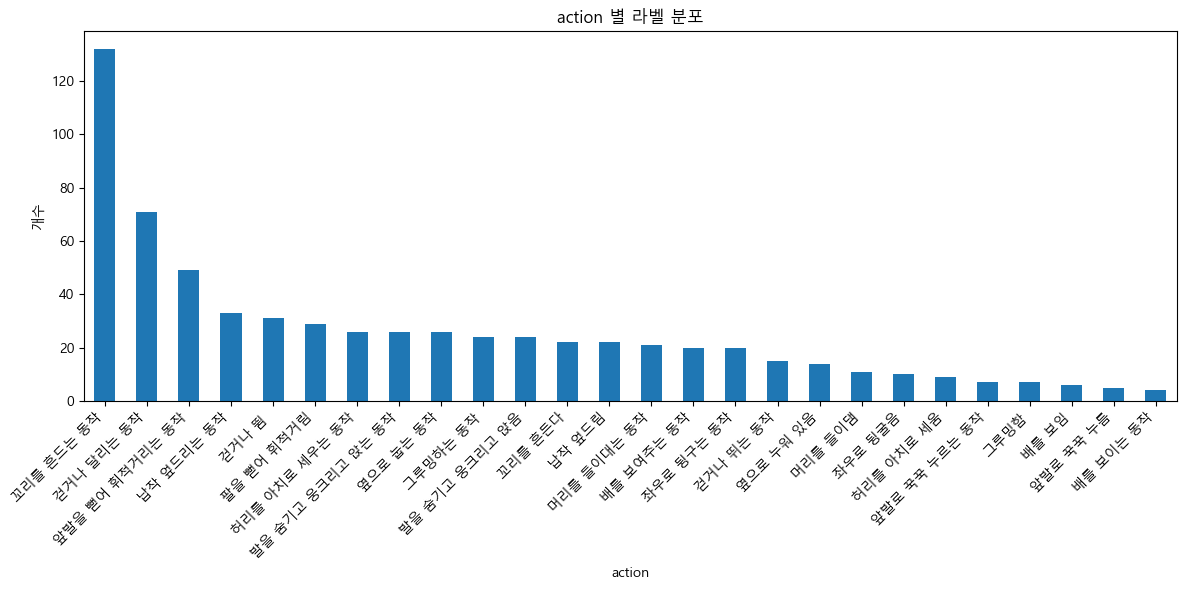

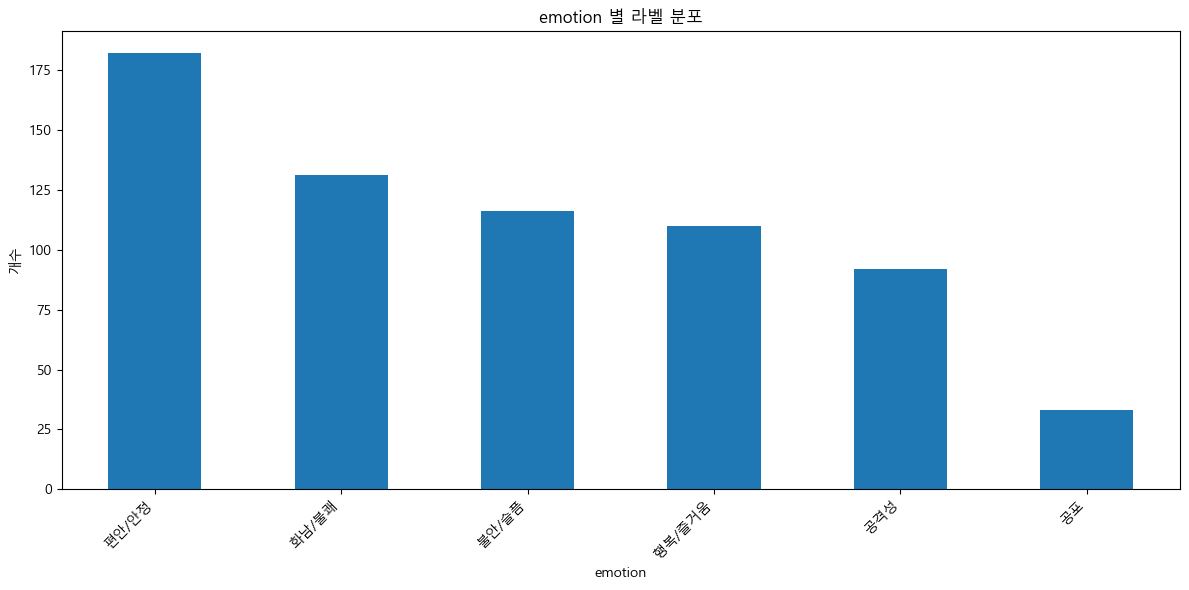

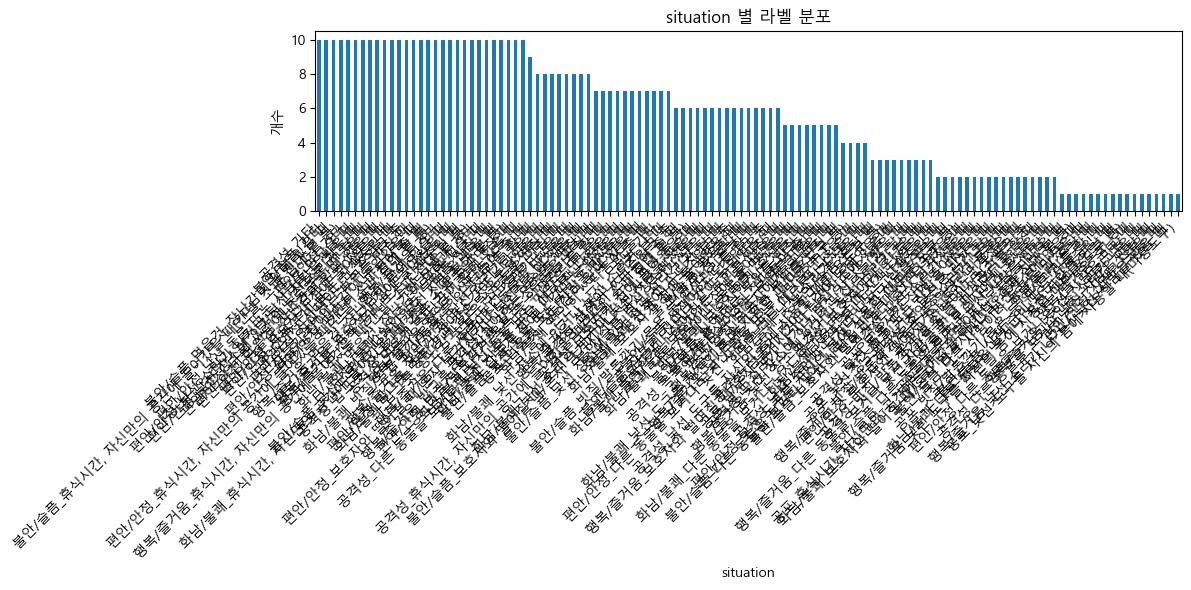

In [ ]:
# 라벨별 분포 확인

import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
df = pd.read_csv(r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\meta_info_sampled_balanced.csv")

# 폰트 설정 (한글 깨질 경우)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ----------- 라벨 분포 그래프 -----------

for column in ['action', 'emotion', 'situation']:
    value_counts = df[column].value_counts()
    
    plt.figure(figsize=(12, 6))
    value_counts.plot(kind='bar')
    plt.title(f"{column} 별 라벨 분포")
    plt.xlabel(column)
    plt.ylabel("개수")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [11]:
# meat_info_sampled 를 이용한 이미지 복사

import os
import pandas as pd
import shutil

# meta_info_sampled.csv 경로
sampled_csv = r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\meta_info_sampled_balanced.csv"

# 원본 CAT 폴더
base_dir = r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT"

# 타겟 CAT_image 폴더
target_dir = os.path.join(base_dir, "CAT_image")
os.makedirs(target_dir, exist_ok=True)

# 샘플링된 video_name 리스트
df = pd.read_csv(sampled_csv)
video_names = set(df['video_name'].tolist())

# 찾은 개수 카운트
count = 0

# os.walk로 모든 폴더 순회
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        if dir_name in video_names:
            src_folder = os.path.join(root, dir_name)
            dst_folder = os.path.join(target_dir, dir_name)
            
            # 폴더 복사 (shutil.copytree 사용)
            try:
                if os.path.exists(dst_folder):
                    print(f"이미 존재해서 건너뜀: {dst_folder}")
                else:
                    shutil.copytree(src_folder, dst_folder)
                    print(f"복사 완료: {dst_folder}")
                    count += 1
            except Exception as e:
                print(f"에러 발생 ({src_folder}): {e}")

print(f"\n총 {count}개 폴더 복사 완료.")


복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201028_cat-arch-000156.mp4
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201114_cat-arch-000925.mp4
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201118_cat-arch-000458.mp4
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201125_cat-arch-000928.mp4
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201202_cat-arch-003532.mp4
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201202_cat-arch-009771.mp4
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\cat-arch-006845
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\cat-arch-007546
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\cat-arch-011926
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\cat-arch-013635
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한

In [12]:
# CAT_iamge 폴더와 이름이 동일한 json 복사

import os
import shutil

# 경로 설정
base_dir = r"C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT"
target_dir = os.path.join(base_dir, "CAT_image")

# video_name 리스트 (이미 폴더가 만들어져 있음)
video_name_list = [d for d in os.listdir(target_dir) if os.path.isdir(os.path.join(target_dir, d))]

# 전체 CAT 폴더에서 json 파일 검색 후 복사
for video_name in video_name_list:
    # json 파일명
    json_filename = f"{video_name}.json"
    
    json_found = False
    
    # CAT 폴더 전체 순회하면서 해당 json 찾기
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == json_filename:
                src_json_path = os.path.join(root, file)
                dst_json_path = os.path.join(target_dir, video_name, json_filename)
                
                try:
                    shutil.copy2(src_json_path, dst_json_path)
                    print(f"복사 완료: {dst_json_path}")
                    json_found = True
                except Exception as e:
                    print(f"에러 발생 ({src_json_path}): {e}")
                break  # 찾았으면 for문 탈출
        if json_found:
            break  # 상위 루프 탈출
    
    if not json_found:
        print(f"[경고] 해당 json 파일 없음: {json_filename}")

print("\njson 파일 복사 작업 완료!")


복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201028_cat-arch-000156.mp4\20201028_cat-arch-000156.mp4.json
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201029_cat-footpush-000231.mp4\20201029_cat-footpush-000231.mp4.json
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201029_cat-getdown-000236.mp4\20201029_cat-getdown-000236.mp4.json
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201030_cat-grooming-000289.mp4\20201030_cat-grooming-000289.mp4.json
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201105_cat-sitdown-000613.mp4\20201105_cat-sitdown-000613.mp4.json
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201110_cat-laydown-001126.mp4\20201110_cat-laydown-001126.mp4.json
복사 완료: C:\Users\SYR\Desktop\AI\반려동물 구분을 위한 동물 영상\Training\CAT\CAT_image\20201114_cat-arch-000925.mp4\20201114_cat-arch-000925.mp4.json
복사 완료: C:\Users\SYR\D